In [115]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import scipy.signal as signal
plt.rcParams.update({'font.size': 15})

from adaptive_filters.LMS import LMS
from adaptive_filters.normLMS import normLMS

# Filtering of noisy ECG signals
In this demo we will use the LMS algorithm for suppressing interference from a signal of interest.
The signal is a measurement of electrical activity of the human heart. This is also known as
an electrocardiogram (ECG). In our case the measurement is contaminated by sinusoidal interference
from the power network

![EKG_problem](img/EKG_problem.png)



## Load noisy data file and find noise frequency

In [116]:
def load_data(path):
    with open(path) as data:
        out = data.readlines()

    return [float(x) for x in out]

In [117]:
path = './ecg.txt'
sample_rate = 500  # Hz
ecg_data = np.array(load_data(path))
ecg_data # /= np.max(ecg_data)

array([-8927.5, -9695.6, -6839.1, ..., -1319.8, -6519.2, -9330.6])

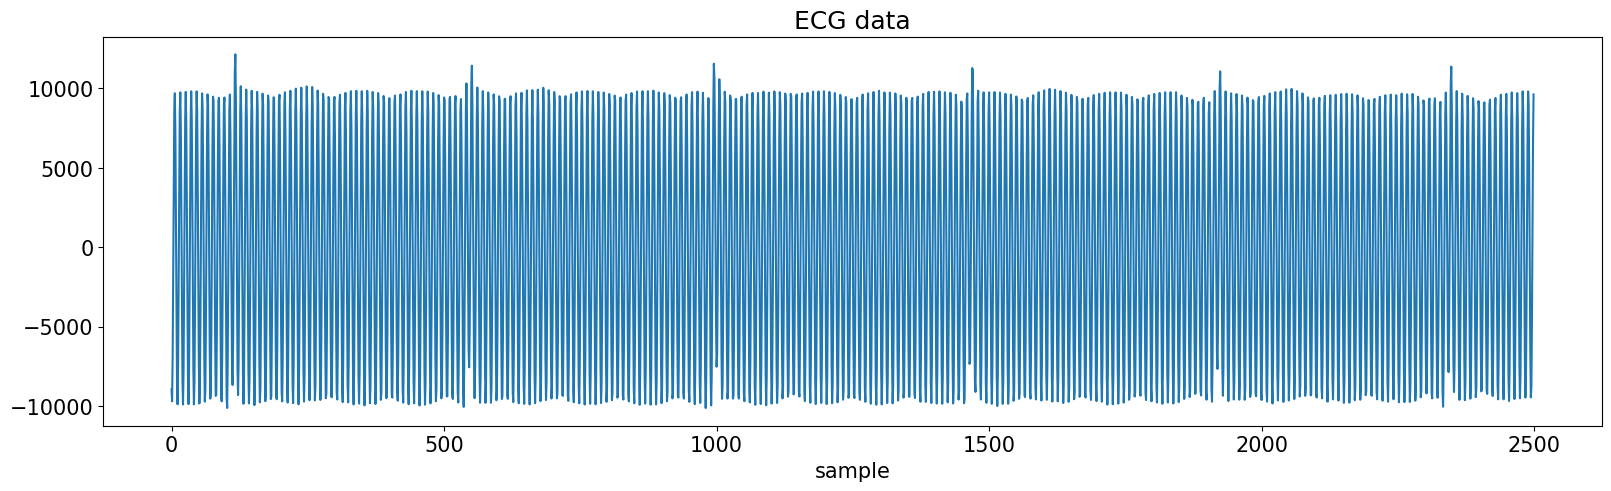

In [118]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data')
ax.plot(ecg_data[:2500])
plt.show()

To remove the power line noise, I use an LMS based algorithm, trying to cancel the noise with a power line frequency signal. To find this noise frequency we estimate the PSD using Bartlett and Welch's method.

In [119]:
_, ecg_spectrum = signal.welch(ecg_data, fs=sample_rate,nperseg=512)
norm_frequencies = np.linspace(0,1,len(ecg_spectrum))  # in units of pi

In [120]:
peak = np.argmax(ecg_spectrum)

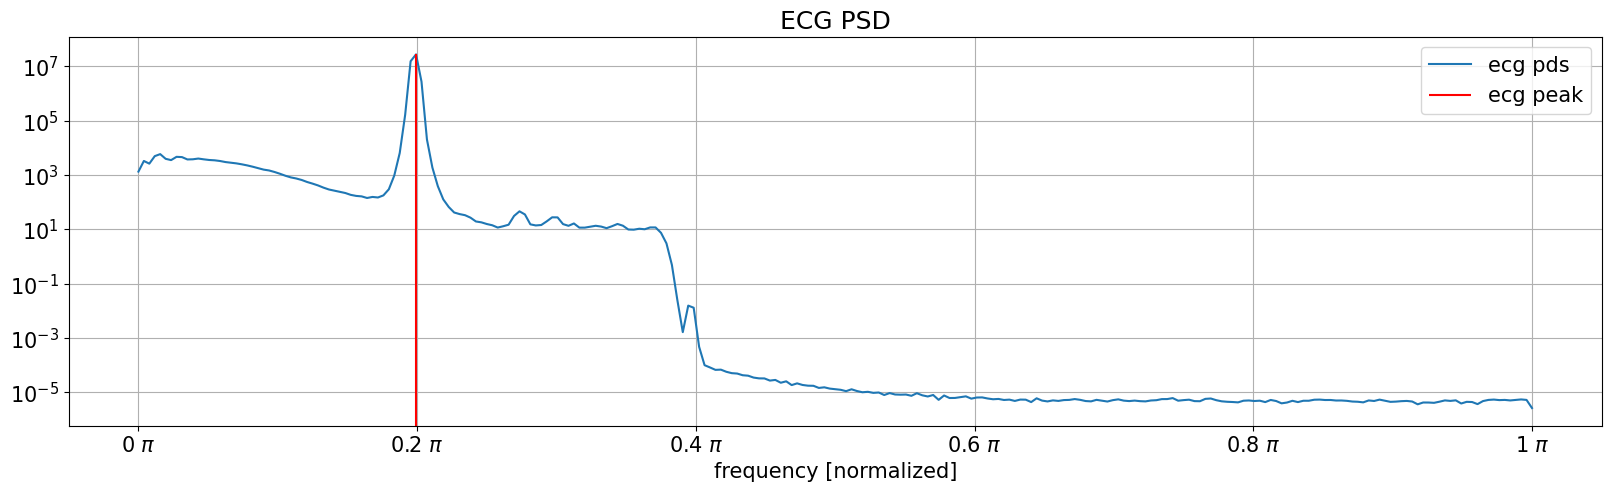

In [121]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG PSD')
ax.semilogy(norm_frequencies, ecg_spectrum, label='ecg pds')
ax.vlines(norm_frequencies[peak], ymin=0, ymax=ecg_spectrum[peak], colors='r', label='ecg peak')
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()

## Simulate noise

In [122]:
noise_frequency = norm_frequencies[peak]
noise = .75*np.sin(np.pi * np.arange(len(ecg_data)) * noise_frequency + np.argmin(ecg_data**2))  # frequency is in units of pi

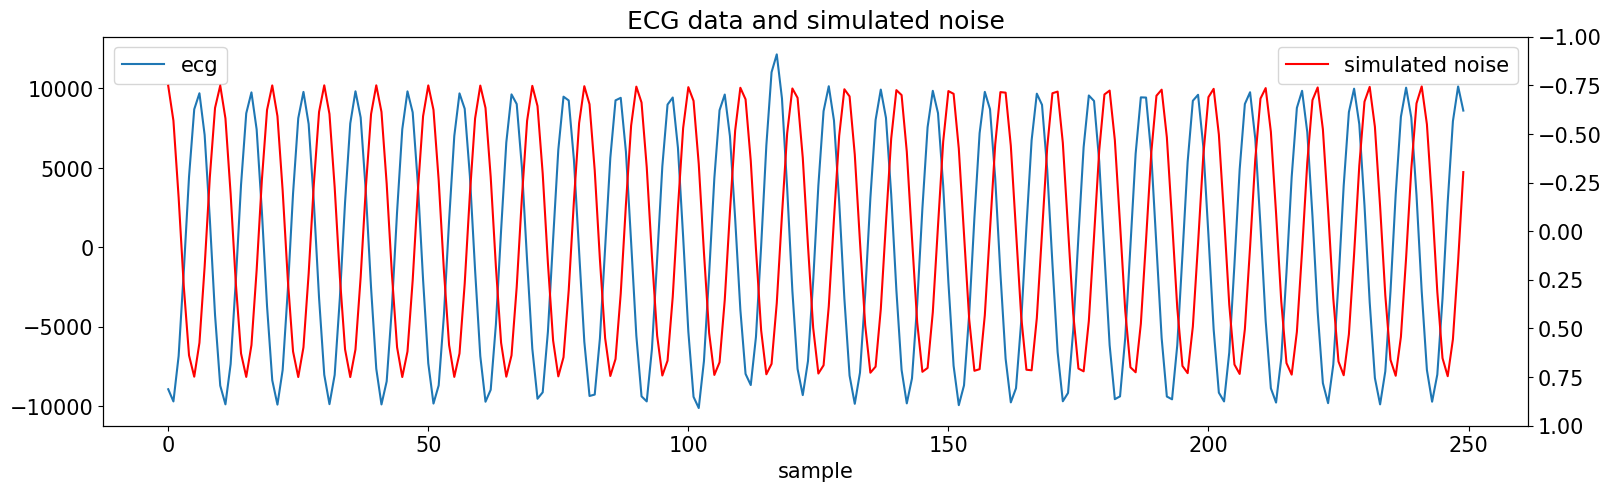

In [123]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data and simulated noise')
signal_plot = ax.plot(ecg_data[:250], label='ecg')

ax2 = ax.twinx()
ax2.set_ylim([1,-1])
noise_plot = ax2.plot(noise[:250], 'r', label='simulated noise')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

## Adaptive filtering

In [124]:
step_size = 1
taps = 10
weights = np.zeros(taps)
lms = normLMS(signal=noise, desired_signal=ecg_data, weights=weights, step_size=step_size)

lms = normLMS(signal=noise, desired_signal=ecg_data, weights=weights, mu_heuristic=0.8)
weights = lms.adapt_weights()

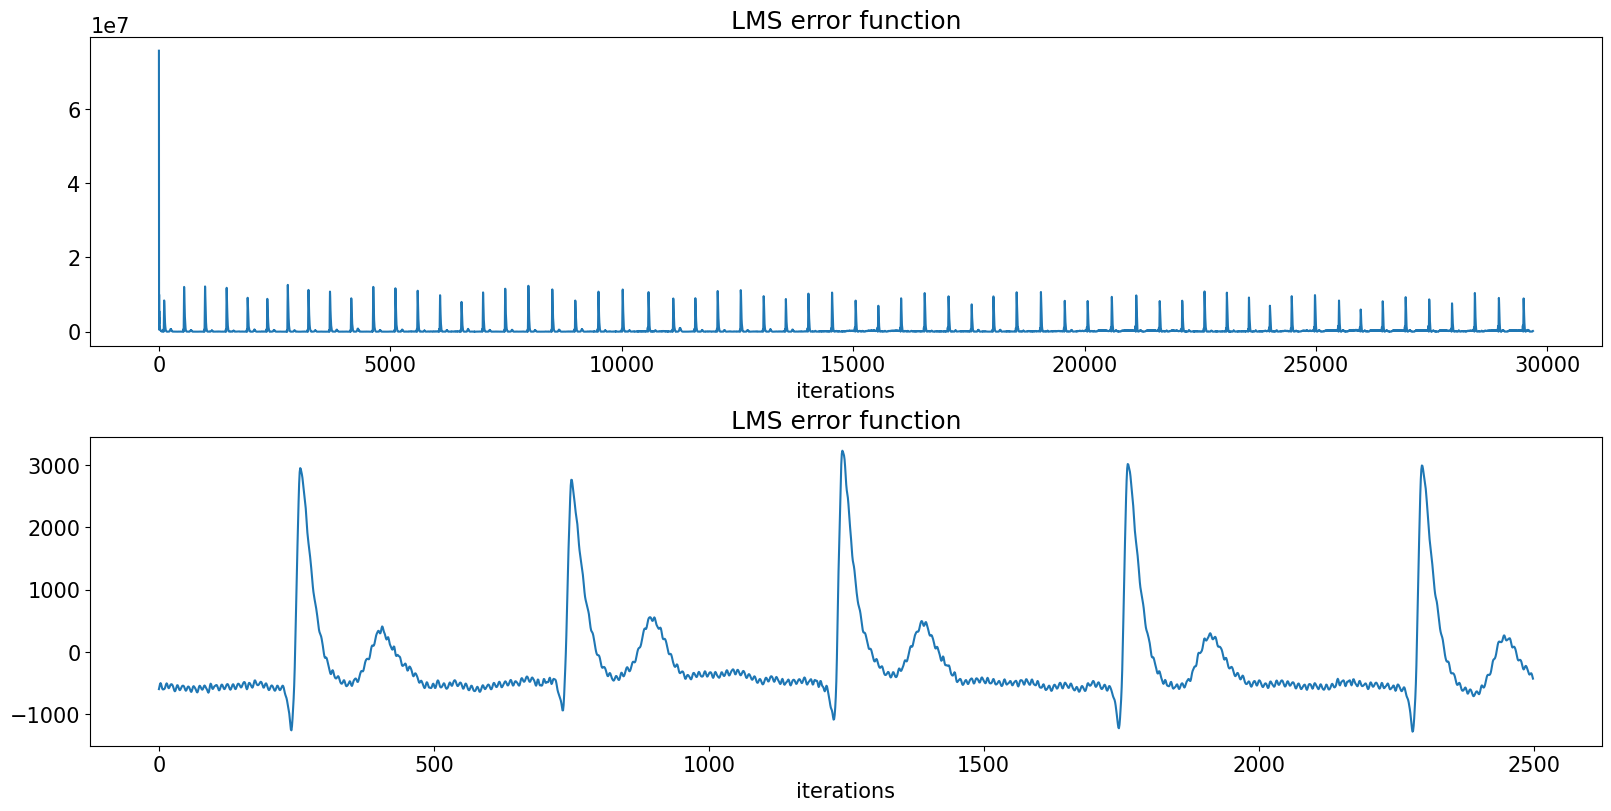

In [125]:
fig, ax = plt.subplots(2, constrained_layout=True)
fig.set_figwidth(16)
fig.set_figheight(8)

ax[0].set_xlabel('iterations')
ax[0].set_title('LMS error function')
ax[0].plot(lms.error**2)

ax[1].set_xlabel('iterations')
ax[1].set_title('LMS error function')
ax[1].plot(lms.error[-2500:])
plt.show()

## Filtered spectrum

In [126]:
_, ecg_spectrum_filt = signal.welch(lms.error, fs=sample_rate,nperseg=512)

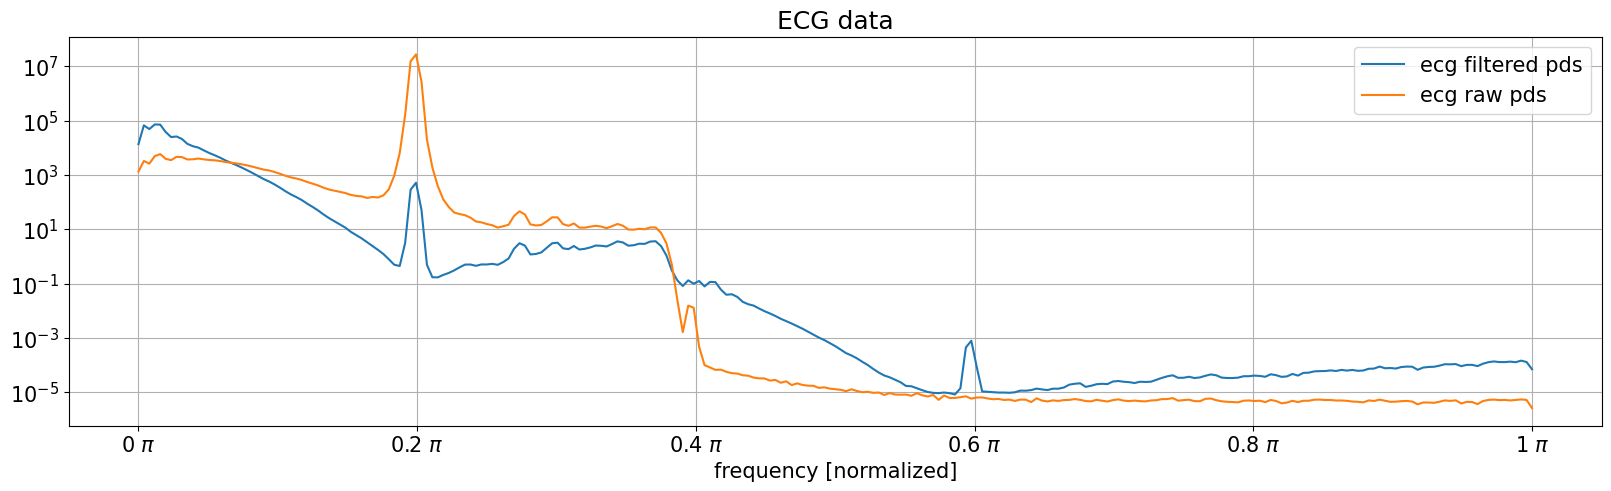

In [127]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG data')
ax.semilogy(norm_frequencies, ecg_spectrum_filt, label='ecg filtered pds')
ax.semilogy(norm_frequencies, ecg_spectrum, label='ecg raw pds')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()

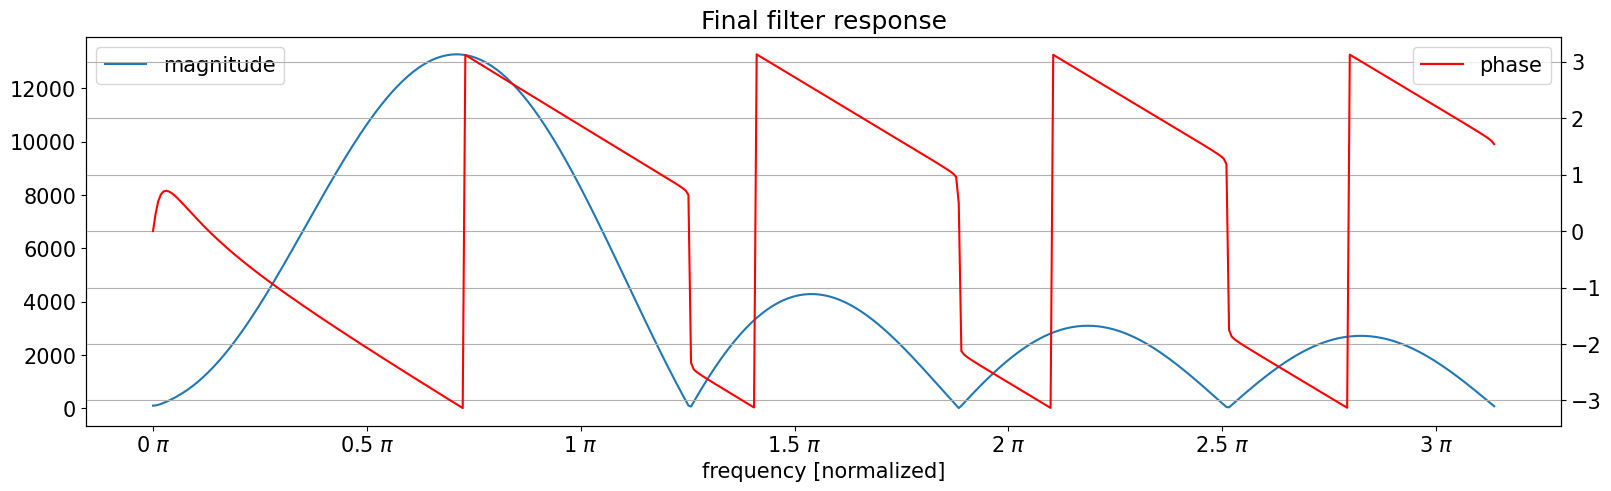

In [128]:
freq, filt_rsp = signal.freqz(weights)

fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('Final filter response')
ax.plot(freq, np.abs(filt_rsp), label='magnitude')
ax2 = ax.twinx()
ax2.plot(freq, np.angle(filt_rsp), 'r', label='phase')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()